In [1]:

%reload_ext autoreload
%autoreload 2
import tensorflow as tf

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)



In [2]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


d:\master3\Master-thesis\Files\func.py:32: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [3]:
#windows_d = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [4]:
target_days = 20

cross = True
return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift, cross)

In [5]:
X_train, X_eval, X_test_full, y_train, y_eval, y_test_full, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [6]:
%reload_ext autoreload
%autoreload 2
holding_period = 3

# Initialize the portfolios




# Initialize model storage dictionary
model_storage = {
    'lgb': {},
    'ridge': {},
    'NN': {},
    'benchmark': {},
}

df_2_read_storage = {}
signals_dfs_storage = {}
portfolio_dfs_storage = {}
X_test_storage = {}

last_two_rows = None


# Initial training and testing periods
end_train_date = df.loc[X_eval.index.max(), 'todate']
end_test_date = df.loc[X_eval.index.max(), 'todate'] + pd.DateOffset(years=holding_period)
start_train_idx = df.index.min()
end_train_idx = X_eval.index.max()

if end_test_date not in df[date_col]:
    end_test_idx = df.index[df[date_col] <= end_test_date].max()
else:
    end_test_idx = df.index.get_loc(end_test_date)

end_test_date_set_to_max = False

print(f"Initial training period: {start_train_idx}, {df.loc[y_train.index.min(), 'todate']} to {end_train_idx}, {df.loc[y_eval.index.max(), 'todate']}")
print(f"Initial testing period: {end_train_idx + 1}, {df.loc[end_train_idx+1, 'todate']} to {end_test_idx},{df.loc[end_test_idx, 'todate']}")


# Define model parameters and training functions here

while pd.to_datetime(end_test_date) <= df['todate'].max():
    # Slice the training and test datasets based on the dates
    """    if last_two_rows is not None:
        X_test = X_test_full.loc[end_train_idx:end_test_idx]
        y_test = y_test_full.loc[end_train_idx :end_test_idx]
    else:"""
    X_test = X_test_full.loc[end_train_idx + 1:end_test_idx]
    y_test = y_test_full.loc[end_train_idx + 1:end_test_idx]
    print(f"New training period: {start_train_idx} to {end_train_idx}")

    # Check if X_test and y_test are not empty
    if X_test.empty or y_test.empty:
        break

    # Define model parameters
    param_grid_NN = {
        'optimizer': ['adam', 'rmsprop'],
        'epochs': [50],
        'batch_size': [64]
    }

    NN_model, best_params, X_test_scaled = optimize_and_train_NN(X_train, y_train, X_eval, y_eval, X_test, param_grid_NN, cross, random_seed)

    param_grid_alpha = {'alpha': [0.1, 1.0, 10.0]}
    ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_eval, y_eval, param_grid_alpha, cross, random_seed)

    param_grid_lgb = {
        'max_depth': [3, 6, 10],
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 63, 127, 255]
    }


    lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb, cross, random_seed)

    # Store models in the dictionary
    model_storage['lgb'][end_train_date] = lgb_best
    model_storage['ridge'][end_train_date] = ridge_best
    model_storage['NN'][end_train_date] = NN_model
    model_storage['benchmark'][end_train_date] = None
    
    
    # Store df_2_read and associated data
    df_2 = df.loc[X_test.index]
    df_2_read = df_read.loc[df_2[date_col].unique()]
    df_2_read.fillna(0, inplace=True)
    df_2_read_storage[end_train_date] = df_2_read

    df_2_neutral = df_2_read.copy()
    df_2_neutral.loc[:, :] = 0

    signals_dfs_storage[end_train_date] = {
        'lgb': df_2_neutral.copy(),
        'ridge': df_2_neutral.copy(),
        'NN': df_2_neutral.copy(),
        'benchmark': df_2_neutral.copy()
    }

    portfolio_dfs_storage[end_train_date] = {
        'lgb': df_2_neutral.copy(),
        'ridge': df_2_neutral.copy(),
        'NN': df_2_neutral.copy(),
        'benchmark': df_2_neutral.copy()
    }
    X_test_storage[end_train_date] = X_test



    end_train_date = end_test_date
    end_test_date = pd.to_datetime(end_test_date) + pd.DateOffset(years=holding_period)
    if pd.to_datetime(end_test_date) > df['todate'].max():
        if not end_test_date_set_to_max:
            print("Reached the end of available data in first iteration.")
            end_test_date = df['todate'].max()
            end_test_date_set_to_max = True
            if end_test_date not in df[date_col]:
                end_test_idx = df.index[df[date_col] <= end_test_date].max()
            else:
                end_test_idx = df.index.get_loc(end_test_date)
            print(f"Updated end_test_idx to last date: {end_test_idx}")  
        else:
            print("Reached the end of available data.")
            break

    

    X_combined = pd.concat([X_train, X_eval, X_test])
    y_combined = pd.concat([y_train, y_eval, y_test])

    split_idx = len(X_combined) // 2

    # Update X_train and X_eval with the first and second halves of the combined data
    X_train = X_combined.iloc[:split_idx]
    X_eval = X_combined.iloc[split_idx:]

    # Update y_train and y_eval similarly
    y_train = y_combined.iloc[:split_idx]
    y_eval = y_combined.iloc[split_idx:]

    # Update start and end indices
    start_train_idx = X_train.index.min()
    end_train_idx = X_eval.index.max()
    if end_test_date not in df[date_col]:
        end_test_idx = df.index[df[date_col] <= end_test_date].max()
    else:
        end_test_idx = df.index.get_loc(end_test_date)

    last_two_rows = "not None"
    


Initial training period: 120225, 1997-07-25 00:00:00 to 319003, 2011-01-05 00:00:00
Initial testing period: 319004, 2011-01-05 00:00:00 to 364402,2014-01-03 00:00:00
New training period: 120225 to 319003


C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'batch_size': 64, 'epochs': 50, 'optimizer': 'adam'}
Epoch 1/50


C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1522/1522 ━━━━━━━━━━━━━━━━━━━━ 2s 977us/step - accuracy: 0.5366 - loss: 0.2482 - val_accuracy: 0.5275 - val_loss: 0.2500
Epoch 2/50
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - accuracy: 0.5535 - loss: 0.2445 - val_accuracy: 0.5255 - val_loss: 0.2505
Epoch 3/50
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step - accuracy: 0.5665 - loss: 0.2418 - val_accuracy: 0.5228 - val_loss: 0.2526
Epoch 4/50
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.5769 - loss: 0.2389 - val_accuracy: 0.5179 - val_loss: 0.2536
Epoch 5/50
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.5872 - loss: 0.2358 - val_accuracy: 0.5208 - val_loss: 0.2554
Epoch 6/50
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.5955 - loss: 0.2329 - val_accuracy: 0.5187 - val_loss: 0.2579
Epoch 7/50
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - accuracy: 0.6044 - loss: 0.2303 - val_accuracy: 0.5169 - val_loss: 0.2590
Epoch 8/50
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - accuracy: 0.6142 - loss: 0.22

C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'batch_size': 64, 'epochs': 50, 'optimizer': 'adam'}
Epoch 1/50


C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1872/1872 ━━━━━━━━━━━━━━━━━━━━ 3s 953us/step - accuracy: 0.5402 - loss: 0.2477 - val_accuracy: 0.5270 - val_loss: 0.2494
Epoch 2/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 2s 899us/step - accuracy: 0.5583 - loss: 0.2448 - val_accuracy: 0.5276 - val_loss: 0.2505
Epoch 3/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 2s 911us/step - accuracy: 0.5634 - loss: 0.2423 - val_accuracy: 0.5232 - val_loss: 0.2528
Epoch 4/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 2s 896us/step - accuracy: 0.5735 - loss: 0.2401 - val_accuracy: 0.5263 - val_loss: 0.2540
Epoch 5/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 2s 887us/step - accuracy: 0.5817 - loss: 0.2376 - val_accuracy: 0.5244 - val_loss: 0.2567
Epoch 6/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step - accuracy: 0.5888 - loss: 0.2354 - val_accuracy: 0.5221 - val_loss: 0.2582
Epoch 7/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 2s 887us/step - accuracy: 0.5954 - loss: 0.2333 - val_accuracy: 0.5189 - val_loss: 0.2603
Epoch 8/50
1872/1872 ━━━━━━━━━━━━━━━━━━━━ 2s 889us/step - accuracy: 0.6002 - loss: 0.23

C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Number of positive: 58639, number of negative: 61128
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 119767, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489609 -> initscore=-0.041570
[LightGBM] [Info] Start training from score -0.041570
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 31}
[LightGBM] [Info] Number of positive: 117495, number of negative: 122040
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 239535, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]

C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'batch_size': 64, 'epochs': 50, 'optimizer': 'adam'}
Epoch 1/50


C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2222/2222 ━━━━━━━━━━━━━━━━━━━━ 3s 941us/step - accuracy: 0.5353 - loss: 0.2480 - val_accuracy: 0.5271 - val_loss: 0.2510
Epoch 2/50
2222/2222 ━━━━━━━━━━━━━━━━━━━━ 2s 893us/step - accuracy: 0.5516 - loss: 0.2450 - val_accuracy: 0.5246 - val_loss: 0.2528
Epoch 3/50
2222/2222 ━━━━━━━━━━━━━━━━━━━━ 2s 898us/step - accuracy: 0.5591 - loss: 0.2432 - val_accuracy: 0.5236 - val_loss: 0.2539
Epoch 4/50
2222/2222 ━━━━━━━━━━━━━━━━━━━━ 2s 896us/step - accuracy: 0.5670 - loss: 0.2412 - val_accuracy: 0.5194 - val_loss: 0.2558
Epoch 5/50
2222/2222 ━━━━━━━━━━━━━━━━━━━━ 2s 898us/step - accuracy: 0.5766 - loss: 0.2392 - val_accuracy: 0.5162 - val_loss: 0.2582
Epoch 6/50
2222/2222 ━━━━━━━━━━━━━━━━━━━━ 2s 882us/step - accuracy: 0.5845 - loss: 0.2371 - val_accuracy: 0.5152 - val_loss: 0.2597
Epoch 7/50
2222/2222 ━━━━━━━━━━━━━━━━━━━━ 2s 893us/step - accuracy: 0.5898 - loss: 0.2350 - val_accuracy: 0.5136 - val_loss: 0.2618
Epoch 8/50
2222/2222 ━━━━━━━━━━━━━━━━━━━━ 2s 893us/step - accuracy: 0.5955 - loss: 0.23

C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'batch_size': 64, 'epochs': 50, 'optimizer': 'adam'}
Epoch 1/50


C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2570/2570 ━━━━━━━━━━━━━━━━━━━━ 3s 942us/step - accuracy: 0.5435 - loss: 0.2475 - val_accuracy: 0.5218 - val_loss: 0.2508
Epoch 2/50
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 2s 890us/step - accuracy: 0.5551 - loss: 0.2450 - val_accuracy: 0.5225 - val_loss: 0.2518
Epoch 3/50
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 2s 897us/step - accuracy: 0.5626 - loss: 0.2432 - val_accuracy: 0.5226 - val_loss: 0.2530
Epoch 4/50
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 2s 894us/step - accuracy: 0.5710 - loss: 0.2414 - val_accuracy: 0.5194 - val_loss: 0.2548
Epoch 5/50
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step - accuracy: 0.5788 - loss: 0.2394 - val_accuracy: 0.5172 - val_loss: 0.2567
Epoch 6/50
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 2s 897us/step - accuracy: 0.5858 - loss: 0.2373 - val_accuracy: 0.5170 - val_loss: 0.2576
Epoch 7/50
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 2s 904us/step - accuracy: 0.5892 - loss: 0.2356 - val_accuracy: 0.5179 - val_loss: 0.2598
Epoch 8/50
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 2s 901us/step - accuracy: 0.5948 - loss: 0.23

C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'batch_size': 64, 'epochs': 50, 'optimizer': 'adam'}
Epoch 1/50


C:\Users\Oscar Azrak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2922/2922 ━━━━━━━━━━━━━━━━━━━━ 4s 942us/step - accuracy: 0.5376 - loss: 0.2480 - val_accuracy: 0.5227 - val_loss: 0.2499
Epoch 2/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 3s 896us/step - accuracy: 0.5503 - loss: 0.2458 - val_accuracy: 0.5214 - val_loss: 0.2509
Epoch 3/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 3s 911us/step - accuracy: 0.5579 - loss: 0.2442 - val_accuracy: 0.5196 - val_loss: 0.2521
Epoch 4/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 3s 907us/step - accuracy: 0.5655 - loss: 0.2426 - val_accuracy: 0.5188 - val_loss: 0.2537
Epoch 5/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 3s 900us/step - accuracy: 0.5718 - loss: 0.2408 - val_accuracy: 0.5163 - val_loss: 0.2562
Epoch 6/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 3s 905us/step - accuracy: 0.5777 - loss: 0.2389 - val_accuracy: 0.5149 - val_loss: 0.2580
Epoch 7/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 3s 903us/step - accuracy: 0.5833 - loss: 0.2372 - val_accuracy: 0.5146 - val_loss: 0.2603
Epoch 8/50
2922/2922 ━━━━━━━━━━━━━━━━━━━━ 3s 907us/step - accuracy: 0.5887 - loss: 0.23

In [17]:

%reload_ext autoreload
%autoreload 2

all_signals = {
    'lgb': pd.DataFrame(),
    'ridge': pd.DataFrame(),
    'NN': pd.DataFrame(),
    'benchmark': pd.DataFrame(),
}


for name, model_dict in model_storage.items():
    k = 0
    print(f"Predicting {name} models")
    for train_date, model in model_dict.items():
        X_test = X_test_storage[train_date]
        # X_test indexes start

        df_2_read = df_2_read_storage[train_date]

        signals_dfs = signals_dfs_storage[train_date]
        portfolio_dfs = portfolio_dfs_storage[train_date]
        #print(f"Training and testing {name} models for {train_date}")
        best_assets, worst_assets = predict_and_analyze_ext(model, X_test_full, df, name, df_read, date_col, cross, top_percentile=80, bottom_percentile=20)
        assets_df = pd.concat([best_assets, worst_assets])
        assets_df['update_value'] = 0
        assets_df.loc[assets_df[name] > assets_df['top_threshold'], 'update_value'] = 1
        assets_df.loc[assets_df[name] < assets_df['bottom_threshold'], 'update_value'] = -1

        pivot_df = assets_df.pivot_table(index='todate', columns='asset', values='update_value', fill_value=0)
        signals_dfs[name].update(pivot_df)
        all_signals[name] = pd.concat([all_signals[name], signals_dfs[name]])



Predicting lgb models
Predicting ridge models
Predicting NN models
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 3s 459us/step
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 3s 462us/step
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 3s 461us/step
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 3s 463us/step
6087/6087 ━━━━━━━━━━━━━━━━━━━━ 3s 464us/step
Predicting benchmark models


In [18]:
# make all_portfolios with dictionary of same df as all_signals but with 0 everywhere

all_portfolios = {
    'lgb': all_signals['lgb'].copy().applymap(lambda x: 0),
    'ridge': all_signals['ridge'].copy().applymap(lambda x: 0),
    'NN': all_signals['NN'].copy().applymap(lambda x: 0),
    'benchmark':  all_signals['benchmark'].copy().applymap(lambda x: 0),
}




for name, dict_ in all_signals.items():
    all_portfolios[name] = update_df_with_asset_performance(all_signals[name].shift(2).dropna(how='all'), all_portfolios[name], target_days, df_read)
    




C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_20920\3818092133.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  'lgb': all_signals['lgb'].copy().applymap(lambda x: 0),
C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_20920\3818092133.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  'ridge': all_signals['ridge'].copy().applymap(lambda x: 0),
C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_20920\3818092133.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  'NN': all_signals['NN'].copy().applymap(lambda x: 0),
C:\Users\Oscar Azrak\AppData\Local\Temp\ipykernel_20920\3818092133.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  'benchmark':  all_signals['benchmark'].copy().applymap(lambda x: 0),


In [19]:
# Store predictions in a dictionary
"""predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")
"""

'predictions = {\n    "Ridge Classifier": ridge_best.predict(X_test),\n    "LightGBM Classifier": lgb_best.predict(X_test),\n    "Neural Network": NN_model.predict(X_test_scaled)\n}   \n\n# Iterate through the dictionary and evaluate each model\nfor model_name, y_pred in predictions.items():\n    print(model_name + ":")\n    if model_name == "Neural Network":\n        y_pred = (y_pred > 0.5).astype(int)\n    evaluate_model_performance(y_test, y_pred)\n    print("\n")\n'

In [20]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test_full.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)

In [21]:
lgb_weights = all_portfolios['lgb']
ridge_weights = all_portfolios['ridge']
NN_weights = all_portfolios['NN']
benchmark_weights = all_portfolios['benchmark']

# shift the weights 2 days

#benchmark_weights = benchmark_weights.shift(2)




lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read
benchmark_returns = benchmark_weights*df_2_read


"""
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)
NN_trade_volume = calculate_trade_volume(NN_weights)"""

'\nlgb_trade_volume = calculate_trade_volume(lgb_weights)\nridge_trade_volume = calculate_trade_volume(ridge_weights)\nNN_trade_volume = calculate_trade_volume(NN_weights)'

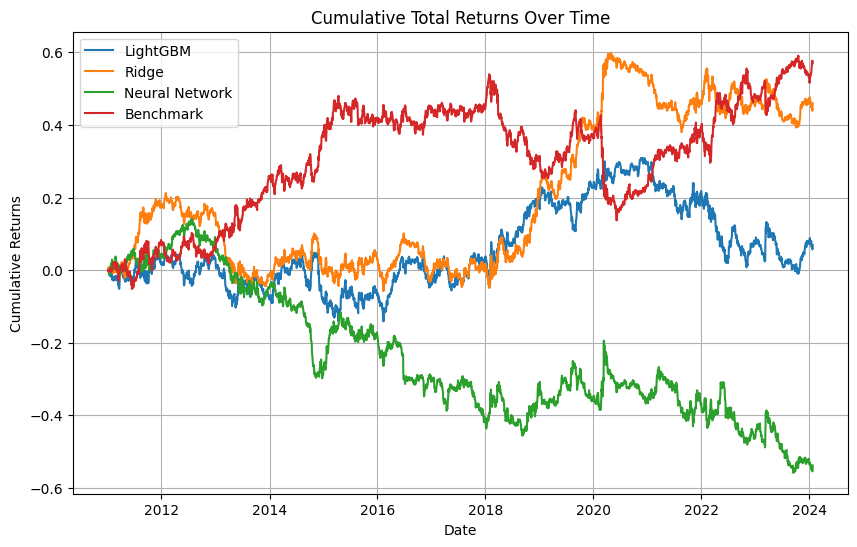

In [22]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)
benchmark_total_returns = benchmark_returns.sum(axis=1)

lgb_cumulative_total_returns = lgb_total_returns.cumsum()
ridge_cumulative_total_returns = ridge_total_returns.cumsum()
NN_cumulative_total_returns = NN_total_returns.cumsum()
benchmark_cumulative_total_returns = benchmark_total_returns.cumsum()

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.plot(benchmark_cumulative_total_returns, label='Benchmark')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [23]:
%reload_ext autoreload
%autoreload 2
ridge_metrics = financial_metrics(ridge_total_returns, ridge_weights)
lgb_metrics = financial_metrics(lgb_total_returns, lgb_weights)
NN_metrics = financial_metrics(NN_total_returns,NN_weights )
benchmark_metrics = financial_metrics(benchmark_total_returns, benchmark_weights)
metrics = {
    "Ridge": ridge_metrics,
    "LightGBM": lgb_metrics,
    "Neural Network": NN_metrics,
    "Benchmark": benchmark_metrics
}

metrics_df1 = pd.DataFrame(metrics).T  


In [24]:
metrics_df1

,Average Yearly Return,Average Yearly Standard Deviation,Yearly Sharpe Ratio,Max Drawdown,Yearly Volatility,Calmar Ratio,Skewness,Kurtosis,Yearly Trades,Yearly Turnover,Yearly Transaction Costs
Ridge,0.034471,0.109835,0.313847,-0.237089,0.109835,0.145394,0.492242,3.581729,477.428571,67.608925,0.006761
LightGBM,0.005192,0.110130,0.047147,-0.273265,0.110130,0.019001,0.430973,3.765209,438.357143,96.077627,0.009608
Neural Network,-0.040383,0.111637,-0.361732,-0.503433,0.111637,-0.080214,0.508225,6.021396,482.857143,121.956906,0.012196
Benchmark,0.042765,0.113692,0.376147,-0.331313,0.113692,0.129076,-0.590814,3.573957,407.785714,35.991517,0.003599


In [25]:
ridge_turnover = ridge_weights.diff().abs().sum(axis=1)
lgb_turnover = lgb_weights.diff().abs().sum(axis=1)
NN_turnover = NN_weights.diff().abs().sum(axis=1)
bench_turnover = benchmark_weights.diff().abs().sum(axis=1)


ridge_trans_cost = ridge_turnover * 0.01 *0.01
lgb_trans_cost = lgb_turnover * 0.01 * 0.01
NN_trans_cost = NN_turnover * 0.01 * 0.01
bench_trans_cost = bench_turnover * 0.01 * 0.01

ridge_adjusted_returns = ridge_total_returns - ridge_trans_cost
lgb_adjusted_returns = lgb_total_returns - lgb_trans_cost
NN_adjusted_returns = NN_total_returns - lgb_trans_cost
bench_adjusted_returns = benchmark_total_returns - bench_trans_cost

ridge_cumulative_total_returns_post_cost = ridge_adjusted_returns.cumsum()
lgb_cumulative_total_returns_post_cost = lgb_adjusted_returns.cumsum()
NN_cumulative_total_returns_post_cost = NN_adjusted_returns.cumsum()
bench_cumulative_total_returns_post_cost = bench_adjusted_returns.cumsum()



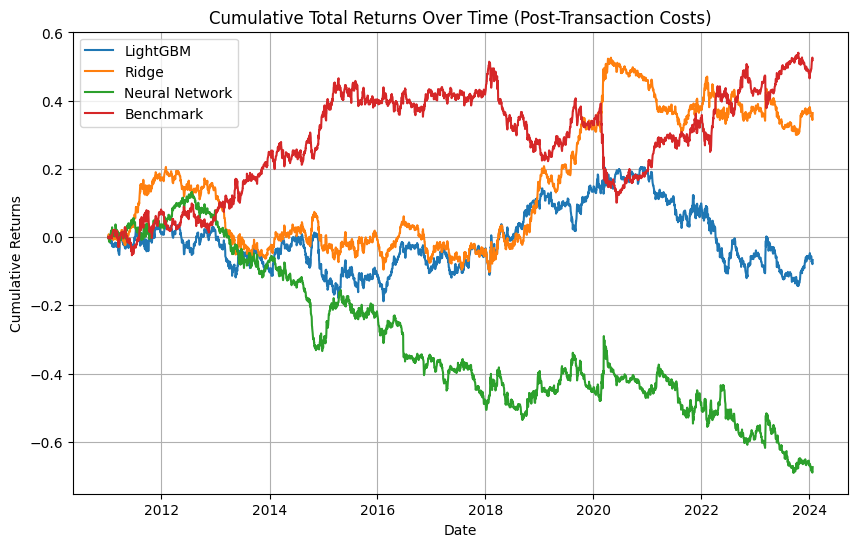

In [26]:



# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns_post_cost, label='LightGBM')
plt.plot(ridge_cumulative_total_returns_post_cost, label='Ridge')
plt.plot(NN_cumulative_total_returns_post_cost, label='Neural Network')
plt.plot(bench_cumulative_total_returns_post_cost, label='Benchmark')
plt.title('Cumulative Total Returns Over Time (Post-Transaction Costs)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

